# Neural Network

In this assignment you will build an artificial neural network _from scratch_, meaning without modern machine learning packages (e.g. scikit-learn, tensorflow, and pytorch). You should use numpy, and can use other standard python libraries if you like. 

## Part 1: Neural Network with Stochastic Gradient Descent (4 points)
Define a class NeuralNetwork that implements an artificial neural network with a single hidden layer. The hidden layer should use the Rectified Linear Unit (ReLU) non-linear activation function, and the output should have a Softmax activation function. Use the template provided. 

This first part should implement SGD with a mini-batch size of 1. This is a simplified case of Part 3, which asks you to implement mini-batch gradient descent with a mini-batch size greater than 1. You should start with Part 1 because it is simpler. However, it is fine to turn in just the solution in Part 3 because that is the more general case.

The hard part of this is the **train** method, which requires computing lots of gradients. See the [notes on neural networks](https://laulima.hawaii.edu/access/content/group/MAN.XLSIDIN35ps.202230/Notes_6__Introduction_to_Neural_Networks.pdf) on Laulima to see the equations for calculating these analytically. Translating these equations into code is non-trivial. The **backpropagation** algorithm is a dynamic programming algorithm that computes the gradients layer by layer, and can be written very elegantly in terms of matrix manipulations (a couple lines of numpy code).

_Reminder: Do NOT copy and paste code from the internet. All code should be written by you._

## Part 2: Apply Your Model to Fashion Dataset (3 points)
We will test the model on the Fashion MNIST dataset. This is a 10-class classification task designed to be similar to the MNIST digit recognition dataset. The classes are different items of clothing (shoes, shirts, handbags, etc.) instead of digits. Here is an [introduction](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) and [github page](https://github.com/zalandoresearch/fashion-mnist).

1. Demonstrate overfitting in your network by plotting the training and test set losses vs. epoch. An *epoch* is one iteration through the training set; in SGD this means one weight update for each training example. You can use a smaller dataset so that you overfit faster, but clearly state how many examples are in your train and test sets.
2. Optimize the hyperparameters of the neural network. You can try different numbers of neurons and the learning rate. Because the test dataset is fairly large (10k examples), you don't need to split off a separate validation set for this analysis. Report the best performance (validation accuracy) and the best hyperparameters. 
3. Visualize the 10 test examples with the largest loss.

## Part 3: Better and Faster: Mini-Batch SGD (3 points)
Implement mini-batch gradient descent in your NeuralNetwork train method. This is much more efficient to update the weights on *batches* of training data, e.g. 100 examples at a time, which serves two purposes: 
1. Each update is a better, less-noisy estimate of the true gradient
2. The matrix multiplications can be parallelized for an almost-linear speedup with multiple cores or a GPU. By default, numpy should automatically use multiple CPUs for matrix multiplications. This requires implementing the forward and backpropagation computations efficiently, using matrix multiplications rather than for loops. 


In [1]:
# Part 1: Defining the neural network.
import numpy as np
import random

class NeuralNetwork():
       
    def __init__(self, inputs, hidden, outputs):
        """
        Initialize a simple neural network with a single hidden layer.
        This method randomly initializes the parameters of the model,
        saving them as private variables.
        
        Each layer is parameterized by a weight matrix and a bias vector; 
        a useful trick is store the weights and biases for a layer together,
        as a single matrix.
        
        Args:
            inputs: int, input dimension
            hidden: int, number of hidden neurons
            outputs: int, number of output neurons
        Returns:
            None
        """
        if(inputs > 0):
            self.inputs = inputs
        else:
            print('Inputs must be greater than zero')
            
        if(hidden > 0):
            self.hidden = hidden
        else:
            print('Number of hidden neurons must be greater than zero')
            
        if(outputs > 0):
            self.outputs = outputs
        else:
            print('Number of output neurons must be greater than zero')
                    
        # Initialize the weights and biases of the neural network as
        # private variables. Store a weight matrix for each layer. 
        
        np.random.seed(0)
                
        # initialize weights and bias for hidden layer
        self.w1 = np.random.randn(inputs, hidden)
        self.b1 = np.random.randn(1, hidden)
        self.wb1 = np.vstack((self.w1, self.b1)) # add row for bias
               
        # initialize weights and bias for output layer
        self.w2 = np.random.randn(hidden, outputs)
        self.b2 = np.random.randn(1, outputs)
        self.wb2 = np.vstack((self.w2, self.b2)) # add row for bias
            
    """ ReLU activation function """
    def relu_activation(self, n_inputs):
        return np.maximum(n_inputs, 0)
    
    """ ReLU derivative function """
    def relu_derivative(self, x):
        if x > 0:
            return 1
        return 0
            
    """ Softmax activation function """
    def softmax_activation(self, n_inputs):
        # softmax is e^input / sum( e^input for all inputs )
        # add axis=1 to perform operation within each row in the matrix
        # subtract the max of the row to prevent overflow error
        try:
            e_values = np.exp(n_inputs - np.max(n_inputs, axis=1).reshape(-1, 1)) # shape (N, D) 
        except:
            print('softmax error')
        return e_values / np.sum(e_values, axis=1).reshape(-1, 1) #change np sum to column to broadcast element division
 
    def predict(self, X):
        """
        Make predictions on inputs X.
        Args:
            X: NxM numpy array where n-th row is an input.
        Returns: 
            y_pred: NxD array where n-th row is vector of probabilities.
        """
        # add column of ones to X so that we can multiply this by the last row of the wb1 matrix (which is the bias)
        # and get the same bias. Then multiply inputs by weights
        # X shape is (N, M+1) 
        X = np.hstack( (X, np.ones( (X.shape[0], 1) ) ) )
            
        # multiply inputs by weights plus a bias
        # X shape is (N, 784+1), self.wb1 is (784+1, # hidden neurons)
        # hidden_preact shape = (N, # hidden neurons)
        hidden_preact = np.dot(X, self.wb1)
        
        # save for back propagation
        self.h_preact = hidden_preact

        # pass through ReLU activation function for each element layout_output
        # relu_output shape = (N, # hidden neurons)
        relu_output = self.relu_activation(hidden_preact)
        
        # take relu_output and multiply by another layer to get to the output vector of 10
        # relu_output shape is (N, # hidden neurons + 1), self.wb2 is shape (# hidden neurons + 1, 10)
        # softmax_preact shape is (N,10)
        
        # add column of ones for bias for relu_output
        relu_output = np.hstack( (relu_output, np.ones( (relu_output.shape[0], 1) )))
        
        # save for back propagation
        self.relu_out = relu_output
        
        softmax_preact = np.dot(relu_output, self.wb2)

        # pass output through softmax activation function to get prediction scores
        # y_pred shape is (N,10)
        y_pred = self.softmax_activation(softmax_preact)
        
        # save for back propagation
        self.yhat = y_pred
                        
        return y_pred
    
    def loss(self, y_true, y_pred):
        """
        Compute categorical cross-entropy loss function. 
        
        Sum loss contributions over the outputs (axis=1), but 
        average over the examples (axis=0)
        
        Args: 
            y_true: NxD numpy array with N examples, D outputs (one-hot labels).
            y_pred: NxD numpy array with N examples, D outputs (probabilities).
        Returns:
            loss: array of length N representing loss for each example.
        """                        
        # sum loss over cross entropy elements
        # clip for log(0) error
        loss = -np.sum(np.ma.log(y_pred) * y_true, axis = 1)
        
        return loss
        
    def evaluate(self, X, y):
        """
        Make predictions and compute loss.
        Args:
            X: NxM numpy array where n-th row is an input.
            y: NxD numpy array with N examples and D outputs (one-hot labels).
        Returns:
            loss: array of length N representing loss for each example.
        """
        predictions = self.predict(X)
        loss = np.mean(self.loss(y_true=y, y_pred=predictions))
        
        return loss
        
    def accuracy(self, y_pred, y_true):
        accuracy = 0
        for i in range(y_true.shape[0]):
            if(y_pred[i].argmax() == y_true[i].argmax()):
                accuracy += 1

        accuracy = accuracy / y_pred.shape[0]
        return accuracy
        
    def train(self, X, y, lr=0.0001, max_epochs=10, x_val=None, y_val=None, batch_size=1):
        """
        Train the neural network using stochastic gradient descent.
        
        Args:
            X: NxM numpy array where n-th row is an input.
            y: NxD numpy array with N examples and D outputs (one-hot labels).
            lr: scalar learning rate. Use small value for debugging.
            max_epochs: int, each epoch is one iteration through the train data.
            x_val: numpy array containing validation data inputs.
            y_val: numpy array containing validation data outputs.
            batch_size: the number of inputs to create a batch with
        Returns:
            history: dict with the following key, value pairs:
                     'loss' -> list containing the training loss at each epoch
                     'loss_val' -> list for the validation loss at each epoch
        """
        # loss history
        history = {'loss': [], 'loss_val': []}
        
        # each epoch is a pass through the model and back
        for epoch in range(max_epochs):

            # make a copy of training data
            X_copy = X.copy()
            y_copy = y.copy()
            
            # keep track of batch losses
            batch_losses = []
            
            # loop through batches of copied training data used to update weights and biases until there is no more
            while X_copy.shape[0] > 0:
                
                # get sample of hyperparameter batch_size to perform stochastic gradient descent with
                # if there is not enough data to to a full batch_size with, use the rest of the training data
                # train_batch_X shape is (min(batch_size, X_copy.shape[0]), 784)
                # train_batch_y  shape is (min(batch_size, y_copy.shape[0]),10)
                
                xt_size = min(batch_size, X_copy.shape[0])
                yt_size = min(batch_size, y_copy.shape[0])               
                
                train_batch_X = X_copy[:xt_size]
                train_batch_y = y_copy[:yt_size]
                                
                # get predictions from batch with randomly initialized weights and biases with first pass
                # but updated weights and biases after backpropagation
                #batch_pred = self.predict(train_batch_X)
                
                # evaluate the loss from batch predictions and append
                # this will set predictions and other variables to what was for the batch
                batch_losses.append(self.evaluate(X=train_batch_X, y=train_batch_y))
                
                # calculate gradients
                
                """ self.wb2 gradient target shape is (# hidden neurons + 1 , 10)
                
                        self.relu_out shape is (batch_size, # hidden neurons + 1)

                        self.relu_out.T shape is (# hidden neurons + 1, batch_size)
                        
                        dldZ shape is (batch_size, 10 )                        
                        
                        np.dot(self.relu_out.T, dldZ) shape is (# hidden neurons + 1, 10)
                """                            
                dLdZ = (self.yhat - train_batch_y) #shape should be (batch_size, 10)
                assert dLdZ.shape == (xt_size, 10)
                assert self.relu_out.T.shape == (self.hidden+1, xt_size)
                dLdW2 = np.dot(self.relu_out.T, dLdZ)
                    
                #update weights and bias for second layer
                try:
                    self.wb2 -= dLdW2 * lr
                except:
                    print('wb2 subtraction error')

                """ self.wb1 target shape is (M+1, # of hidden neurons)
                 
                     dldZ shape is (batch_size, 10 )

                     self.wb2 shape is (# hidden neurons + 1, 10)

                     self.wb2.T shape is (10, # hidden neurons + 1)

                     np.dot(dLdZ, self.wb2.T) shape is (batch_size, # hidden neurons + 1)

                     self.relu_out shape is (batch_size, # hidden neurons + 1)
                     
                     train_batch_X shape is (batch_size, M+1)
                     
                     train_batch_X.T shape is (M+1, batch_size)
                     
                     np.dot(train_batch_X.T, wb1_delta[:,:-1]) shape is (M+1, # of hidden neurons)
                     
                """
                
                # add column of ones to multiply bias by 
                train_batch_X = np.hstack( (train_batch_X, np.ones( (train_batch_X.shape[0], 1) ) ) )
                
                # calculate gradient for layer 1
                wb1_delta = np.dot(dLdZ, self.wb2.T) * (self.relu_out > 0).astype(np.float)                
                
                try:
                    self.wb1 -= np.dot(train_batch_X.T, wb1_delta[:,:-1]) * lr
                except:
                    print('wb1 subtraction error')
                
                X_copy = X_copy[batch_size:]
                y_copy = y_copy[batch_size:]
            
            # evaluate the loss of validation batch with one epoch of trained weights
            loss_val = self.evaluate(x_val, y_val)
                        
            # average losses from batches
            loss = np.mean(batch_losses)
            
            # get accuracy
            #acc = self.accuracy(y_pred=self.predict(x_val), y_true=y_val)            
                        
            # add losses to history dictionary
            history['loss'].append(loss)
            history['loss_val'].append(loss_val)     
        
        return history

In [2]:
# Download Fashion MNIST Dataset
import gzip
import os
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt

def fashion_mnist():
    """
    Download compressed Fashion MNIST data to local directory, and 
    unpack data into numpy arrays. 
    
    Return (train_images, train_labels, test_images, test_labels).

    Args:
        None

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']
    path = './' # Download data to current directory.
    os.makedirs(path, exist_ok=True) # Create path if it doesn't exist.

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = fashion_mnist()

# Plot examples from dataset.
plt.figure(1, figsize=(14,6))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(train_images[i,:].reshape(28,28), cmap='bone')
    plt.title(f'Label: {train_labels[i].argmax()}')
    plt.xticks([])
    plt.yticks([])

In [18]:
#create validation set of data from train_images and train_labels
val_images = train_images[0:18000,:].copy() #this is 30% of the training images
val_labels = train_labels[0:18000,:].copy() #this is 30% of the training labels
train_images_split = train_images[18000:,:].copy()
train_labels_split = train_labels[18000:,:].copy()

In [6]:
#Train neural network
input_neurons = train_images.shape[1] # 784
hidden_neurons = 20
output_neurons = 10

#hyperparameters
max_epoch = 100
learning_rate = 0.00001
batch_size = 1

mnistNN = NeuralNetwork(input_neurons, hidden_neurons, output_neurons) #10 for outputs because the labels are vector of 10
history = mnistNN.train(train_images_split[0:100], train_labels_split[0:100], lr=learning_rate, max_epochs=max_epoch, x_val=val_images, y_val=val_labels, batch_size=batch_size)

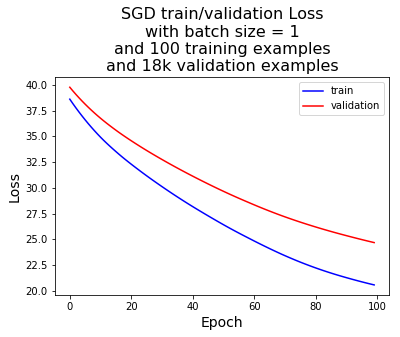

In [11]:
x = range(0, max_epoch)
y = history['loss']
z = history['loss_val']
plt.plot(x, y, 'b', label='train')
plt.plot(x, z, 'r', label='validation')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('SGD train/validation Loss\nwith batch size = 1\nand 100 training examples\nand 18k validation examples', fontsize=16)

plt.legend()
plt.show()

In [29]:
#Train neural network using mini-batches of examples
input_neurons = train_images.shape[1] # 784
hidden_neurons = 20
output_neurons = 10

#hyperparameters
max_epoch = 100
learning_rate = 0.00001
batch_size = 10

mb_mnistNN = NeuralNetwork(input_neurons, hidden_neurons, output_neurons) #10 for outputs because the labels are vector of 10
mb_history = mb_mnistNN.train(train_images_split[0:100], train_labels_split[0:100], lr=learning_rate, max_epochs=max_epoch, x_val=val_images, y_val=val_labels, batch_size=batch_size)

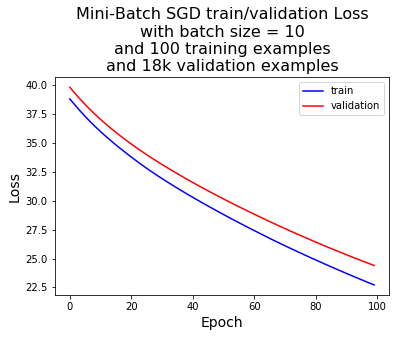

In [30]:
x = range(0, max_epoch)
y = mb_history['loss']
z = mb_history['loss_val']
plt.plot(x, y, 'b', label='train')
plt.plot(x, z, 'r', label='validation')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Mini-Batch SGD train/validation Loss\nwith batch size = 10\nand 100 training examples\nand 18k validation examples', fontsize=16)

plt.legend()
plt.show()

In [33]:
#Tune number of hidden neurons
input_neurons = train_images.shape[1] # 784
output_neurons = 10

#hyperparameters
max_epoch = 100
learning_rate = 0.00001
batch_size = 100

# Try changing the # of neurons
accuracy = {}

for hidden_neurons in range(1,31):
    
    tune_mnistNN = NeuralNetwork(input_neurons, hidden_neurons, output_neurons) #10 for outputs because the labels are vector of 10
    tune_mnistNN.train(train_images_split, train_labels_split, lr=learning_rate, max_epochs=max_epoch, x_val=val_images, y_val=val_labels, batch_size=batch_size)
    
    y_pred = tune_mnistNN.predict(test_images)
    acc = tune_mnistNN.accuracy(y_pred = y_pred, y_true = test_labels)
    accuracy[hidden_neurons] = acc
    
print(accuracy)

{1: 0.0984, 2: 0.1323, 3: 0.1801, 4: 0.3793, 5: 0.243, 6: 0.2903, 7: 0.2683, 8: 0.3397, 9: 0.4747, 10: 0.5923, 11: 0.4233, 12: 0.4582, 13: 0.452, 14: 0.5956, 15: 0.6527, 16: 0.5668, 17: 0.5581, 18: 0.5305, 19: 0.5709, 20: 0.6337, 21: 0.6129, 22: 0.6143, 23: 0.6648, 24: 0.6417, 25: 0.6718, 26: 0.6644, 27: 0.6645, 28: 0.6725, 29: 0.683, 30: 0.6731}


In [35]:
max_acc = 0
max_index = 0
for i in range(1,31):
    if accuracy[i] > max_acc:
        max_acc = accuracy[i]
        max_index = i
print('optimal neurons = ', max_index, ' with accuracy ', max_acc)    

optimal neurons =  29  with accuracy  0.683


In [39]:
#Tune learning rate
input_neurons = train_images.shape[1] # 784
output_neurons = 10

opt_hidden_neurons = 29

#hyperparameters
max_epoch = 100
learning_rate = 0.00001
rate_increase = 0.00001
batch_size = 100

# Try changing the learning rate with optimized # of neurons
opt_lr_accuracy = {}

# try 10 different learning rates
for i in range(10):
    
    lr_tune_mnistNN = NeuralNetwork(input_neurons, opt_hidden_neurons, output_neurons) #10 for outputs because the labels are vector of 10
    lr_tune_mnistNN.train(train_images_split, train_labels_split, lr=learning_rate, max_epochs=max_epoch, x_val=val_images, y_val=val_labels, batch_size=batch_size)
    
    y_pred = lr_tune_mnistNN.predict(train_images)
    acc = lr_tune_mnistNN.accuracy(y_pred = y_pred, y_true = train_labels)
    opt_lr_accuracy[i] = acc
    
    learning_rate += rate_increase
    

In [40]:
max_lr_acc = 0
max_lr_index = 0
for i in range(10):
    if opt_lr_accuracy[i] > max_lr_acc:
        max_lr_acc = opt_lr_accuracy[i]
        max_lr_index = i
print('optimal learning rate = ', max_lr_index, ' with accuracy ', max_lr_acc)    

optimal learning rate =  5  with accuracy  0.7708666666666667


With a mini-batch size of 100, the optimal learning rate and number of hidden neurons for my model is 29 hidden neurons and a learning rate of 0.00006

In [44]:
# Test Data Mini-Batch SGD Loss using optimized hyperparamters
input_neurons = train_images.shape[1] # 784
output_neurons = 10
max_epoch = 100
batch_size = 100

# hyperparamters
opt_hidden_neurons = 29
opt_learning_rate = 0.00006

# create neural network with optimized hyperparameters
opt_mnistNN = NeuralNetwork(input_neurons, opt_hidden_neurons, output_neurons) #10 for outputs because the labels are vector of 10

# train with 42K examples set and test with held out test set of 10K examples
opt_history = opt_mnistNN.train(train_images_split, train_labels_split, lr=opt_learning_rate, max_epochs=max_epoch, x_val=test_images, y_val=test_labels, batch_size=batch_size)

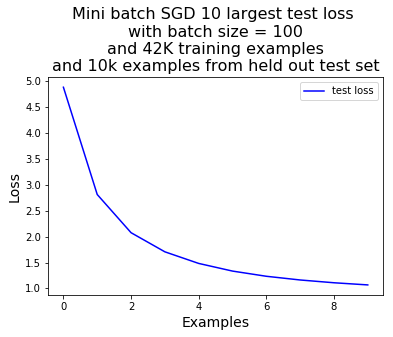

In [49]:
# 10 largest loss of test data
sorted_opt_history = np.sort(opt_history['loss_val'])[::-1]

x = range(10)
y = sorted_opt_history[0:10]
plt.plot(x, y, 'b', label='test loss')
plt.xlabel('Examples', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Mini batch SGD 10 largest test loss \nwith batch size = 100\nand 42K training examples\nand 10k examples from held out test set', fontsize=16)

plt.legend()
plt.show()